In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import MulensModel as mm
plt.rcParams["figure.figsize"] = (15,5)
import seaborn as sns
sns.set_theme(style='ticks', font_scale=1.4, font="serif")
from matplotlib import rc
import matplotlib as mpl
from microjax.point_source import critical_and_caustic_curves, mag_point_source
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax import config 
config.update('jax_enable_x64', True) 
import jax.numpy as jnp
from jax import grad, jit, vmap, random
from microjax.inverse_ray.lightcurve import mag_lc
from microjax.trajectory import dtn_dum_parallax, _get_info_parallax

In [7]:
data = pd.read_csv("../data/ogle-2014-blg-0124/phot.dat", delim_whitespace=True,header=None, names=["HJD", "mag", "mage", "seeing", "sky"])
data["HJD"] -= 2450000
#data = data[(data.HJD>2.4563e+6)]
#data = data[(data.HJD>2.4566e+6)&(data.mage<0.4)]
data = data[(data.HJD>6300)]
mag0 = 18.0
data["flux"] = 10**(-0.4*(data.mag - mag0))
data["fluxe"] = data.flux * 0.4 * np.log(10) * data.mage

In [8]:
# initial guess
_t_0, _u_0, _t_E = 6.83640951e+03, 2.24211333e-01, 1.33559958e+02 
_s, _q, _alpha = 9.16157288e-01, 5.87559438e-04, 1.00066409e+02
_rho, _pi_E_N, _pi_E_E = 2.44003713e-03, 1.82341182e-01,9.58542572e-02
_fs, _fb = 8.06074085e-01, 8.62216897e-01
_f_sum = _fs + _fb
theta_0 = jnp.array([_t_0, _u_0, _t_E, _s, _q, _alpha, _rho, _pi_E_N, _pi_E_E, _fs, _fb])
params_mm = {'t_0': _t_0, 'u_0': _u_0, 't_E': _t_E, 's': _s, 'q': _q, 'alpha': _alpha, 'rho': _rho, 'pi_E_N': _pi_E_N, 'pi_E_E': _pi_E_E}
from astropy.coordinates import SkyCoord
coords = SkyCoord("18:02:29.21 −28:23:46.5", unit=("hourangle", "deg"))
coords_deg = (coords.ra.deg, coords.dec.deg)
model = mm.Model(parameters=params_mm, coords=coords)
model.set_default_magnification_method("VBBL")
time_plot = jnp.linspace(6350,7000,2000)
amp_mm = model.get_magnification(time_plot)
s_t = model.get_trajectory(time_plot)


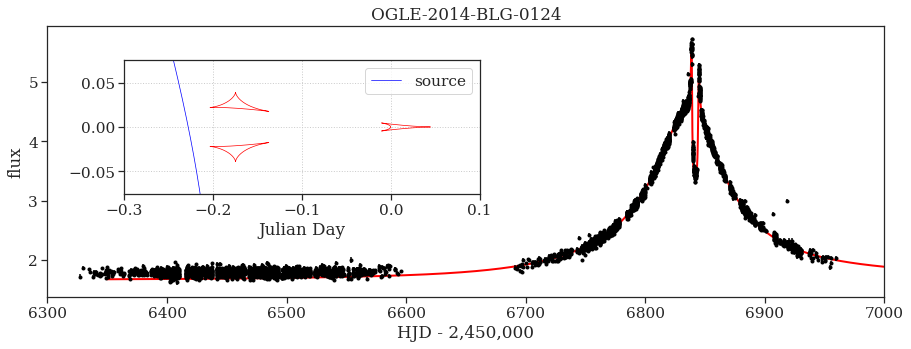

In [9]:
from microjax.point_source import critical_and_caustic_curves
critical_curves, caustic_curves = critical_and_caustic_curves(nlenses=2, npts=500, s=_s, q=_q)
fig,ax = plt.subplots()
ax_in = inset_axes(ax,
        width="70%", height="70%", 
        bbox_transform=ax.transAxes,
        loc='upper left', 
        bbox_to_anchor=(0.05, 0.2, 0.7, 0.7)
        #bbox_to_anchor=(0.0, 0.0, 0.4, 0.4)
    )
ax_in.set_aspect(1)
for cc in caustic_curves:
    ax_in.plot(cc.real, cc.imag, color='red', lw=0.7)
ax_in.plot(s_t.x, s_t.y, color='blue', lw=0.7, label="source")
ax_in.set(xlim=(-0.3, 0.1), ylim=(-0.075, 0.075))
ax_in.legend()
ax.plot(time_plot, amp_mm*_fs + _fb, "-", lw=2, color="red", label="MulensModel")
ax.errorbar(data.HJD, data.flux, yerr=data.fluxe, fmt='.', color='black', label="OGLE-I")
ax.set_title("OGLE-2014-BLG-0124")
ax.set_xlabel("HJD - 2,450,000")
ax.set_ylabel("flux")
ax.set_xlim(6300,7000)
plt.legend()
plt.grid(ls=":")
plt.plot(time_plot, amp_mm*_fs + _fb, "-", lw=2, color="red", label="MulensModel")
plt.errorbar(data.HJD, data.flux, yerr=data.fluxe, fmt='.', color='black', label="OGLE-I")
plt.xlabel("Julian Day")
plt.show()

In [10]:
from astropy.coordinates import SkyCoord
coords = SkyCoord("18:02:29.21 −28:23:46.5", unit=("hourangle", "deg"))
coords_deg = (coords.ra.deg, coords.dec.deg)
tref = 6836.0
info_parallax = _get_info_parallax(RA=coords_deg[0], Dec=coords_deg[1], tref=tref)
t_peri, qne0, vne0, xpos, ypos, north, east = info_parallax

In [11]:
_t_0, _u_0, _t_E = 6.83640951e+03, 2.24211333e-01, 1.33559958e+02 
_s, _q, _alpha = 9.16157288e-01, 5.87559438e-04, 1.00066409e+02
_rho, _pi_E_N, _pi_E_E = 2.44003713e-03, 1.82341182e-01,9.58542572e-02
_fs, _fb = 8.06074085e-01, 8.62216897e-01
_f_sum = _fs + _fb
theta_0 = jnp.array([_t_0, _u_0, _t_E, _s, _q, _alpha, _rho, _pi_E_N, _pi_E_E, _fs, _fb])

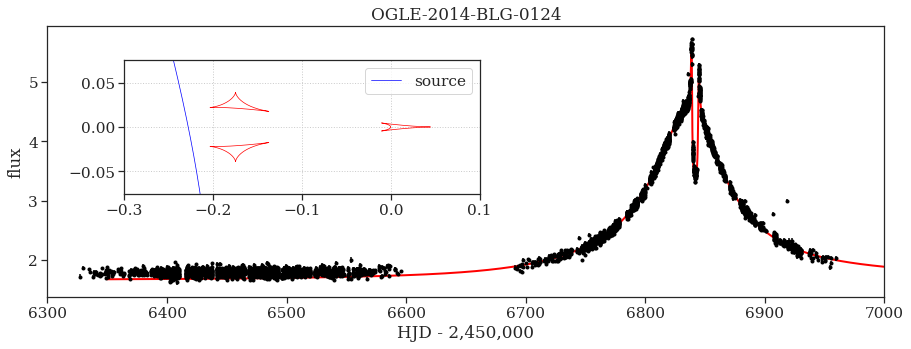

In [12]:
params_mm = {'t_0': _t_0, 'u_0': _u_0, 't_E': _t_E, 's': _s, 'q': _q, 'alpha': _alpha, 'rho': _rho, 'pi_E_N': _pi_E_N, 'pi_E_E': _pi_E_E}
model = mm.Model(parameters=params_mm, coords=coords)
model.set_default_magnification_method("VBBL")
time_plot = jnp.linspace(6350,7000,2000)
amp_mm = model.get_magnification(time_plot)
s_t = model.get_trajectory(time_plot)
import matplotlib as mpl
from microjax.point_source import critical_and_caustic_curves, mag_point_source
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig,ax = plt.subplots()
ax_in = inset_axes(ax,
        width="70%", height="70%", 
        bbox_transform=ax.transAxes,
        loc='upper left', 
        bbox_to_anchor=(0.05, 0.2, 0.7, 0.7)
        #bbox_to_anchor=(0.0, 0.0, 0.4, 0.4)
    )
critical_curves, caustic_curves = critical_and_caustic_curves(nlenses=2, npts=500, s=_s, q=_q)
ax_in.set_aspect(1)
for cc in caustic_curves:
    ax_in.plot(cc.real, cc.imag, color='red', lw=0.7)
ax_in.plot(s_t.x, s_t.y, color='blue', lw=0.7, label="source")
ax_in.set(xlim=(-0.3, 0.1), ylim=(-0.075, 0.075))
ax_in.legend()
ax.plot(time_plot, amp_mm*_fs + _fb, "-", lw=2, color="red", label="MulensModel")
ax.errorbar(data.HJD, data.flux, yerr=data.fluxe, fmt='.', color='black', label="OGLE-I")
ax.set_title("OGLE-2014-BLG-0124")
ax.set_xlabel("HJD - 2,450,000")
ax.set_ylabel("flux")
ax.set_xlim(6300,7000)
plt.legend()
plt.grid(ls=":")
#plt.savefig("example/ob140124/ob140124_data.pdf")
plt.show()